# My first landscape

In this notebook, we will use the basic `trackscape` module, aka without the python helper, to run from scratch a simple fluvial landscape.

## Importing the right codes

First let's import the different modules we will use:

- matplotlib for the visualisation
- numpy for generating input data
- popscape_dagger for the model
- Note the `%matplotlib wdiget` is an optional widget to get interactive figures

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import dagger as psc


%matplotlib widget



ny,nx = 256,256
dy,dx = 200,200

Urate = np.zeros((ny,nx)) + 5e-4
Urate[round(2*ny/3):,:] = 0

dt = 500
Kr = 2e-5
Ks = 4e-5

κ_s = 1.5e-3
κ_r = 1e-3

dep = 1
rshp = (ny,nx)

## Setting up model object

`python` and `c++` are object oriented lanuages. An object is a set of data and function associated together to operate smoothly, and that's where we control the model behavior. 

Note here that we initialise the model with white noise - further options will come soon. We will also demonstrate other boundary conditions, `"4edges"` means that all the boundaries outlets the model.

For this first example, we also set the hillslope processes off. By default, the model is set to run in Single Flow Direction mode.

In [80]:
# Initialising an empty model in the variable ts
ts = psc.trackscape()
# Initialising the topography and its dimensions
ts.init_random(nx, ny,dx,dy,"periodic_EW")
# ts.init_perlin(nx, ny,dx,dy,"periodic_EW", 5,8, 10,42, False)

# FUnctions to set parameters as global homogeneous values (if not initialised, there is a default value)
ts.set_single_Kr(Kr)
ts.set_single_Ks(Ks)
ts.set_single_depcoeff(dep)

ts.set_dt(dt)
ts.set_fluvial_mode(psc.TSC_FLUVIAL.DAVY2009)
# ts.set_fluvial_mode(psc.TSC_FLUVIAL.NONE)
ts.set_hillslopes_mode(psc.TSC_HILLSLOPE.CIDRE)
# ts.set_fluvial_mode(psc.TSC_FLUVIAL.FASTSCAPE)
ts.set_flowtopo_mode(psc.TSC_FLOW_TOPOLOGY.MFD)

ts.graph.set_LMR_method(psc.LMR.cordonnier_carve)

ts.set_single_depcoeff(dep)
ts.set_single_Kr(Kr)
ts.set_single_Ks(Ks)

ts.set_single_kappa_r(κ_r)
ts.set_single_kappa_s(κ_s)


# Deactivate hilllsopes processes
# ts.hillslopes_off()

## Running the model

Finally we can run the model. The model has a `run` function that automatically runs one timestep with the options inputted. We set up an interractive plot, this is not the most instinctive way to visualise, but it is satisfying. Another notebook will detail the different outputs.


This first cell generates the figure:

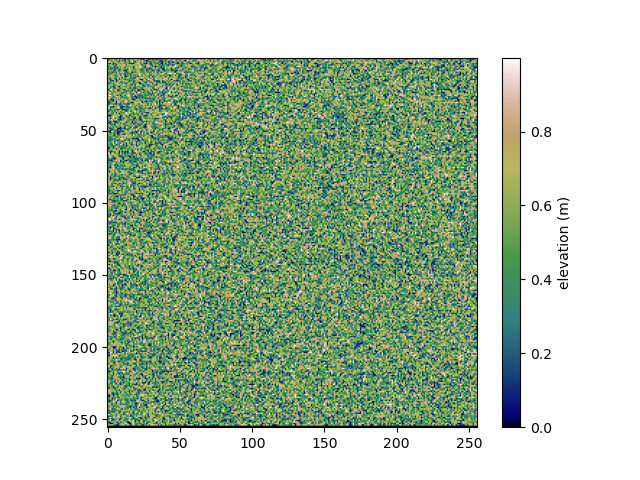

In [81]:
fig,ax = plt.subplots()
topo = ts.get_topo().reshape(rshp)
# topo = ts.get_Qw().reshape(rshp)
im = ax.imshow(topo, cmap = "gist_earth")
plt.colorbar(im, label = "elevation (m)")

**Let's now run the model `ndt` times, and update the figure every `nupdate` timesteps** (updating the figure too often can be costly).

> **Note** the figure is updated in place, just above. If you deactivated the widget, it won't work

In [82]:
ndt = 100000
nupdate = 100

# Main loop
for i in range(ndt):
    if(i<1000):
        ts.set_dt(dt/2)
    else:
        ts.set_dt(dt)     

    ts.run()
    # ts.run_SFD(dt)
    ts.external_uplift(Urate, dt, True)
    
    # If nupdate^th timestep: I update the fig
    if(i%nupdate == 0):
        ## printing the timestep
        print("                   ",end = "\r")
        print("Timestep",i,end = "\r")
        
        #GEtting the topography
        topo = ts.get_topo().reshape(rshp)
        # topo = ts.get_Qw().reshape(rshp)
        # Setting the new data
        im.set_data(topo)
        # Setting the new colorbar limits
        im.set_clim(topo.min(), topo.max())
        # Apply the update
        fig.canvas.draw()
        
        
        
        

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
A = ts.graph.accumulate_variable_downstream_SFD(ts.connector, prec)
A = ts.get_Qw()
A = ts.get_precipitations()
cb = ax.imshow(A.reshape(rshp))
# cb = ax.imshow(prec.reshape(rshp))
plt.colorbar(cb)

In [4]:
%timeit ts.run()

6.51 ms ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%timeit ts.run_SFD_implicit(dt)

6.18 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit ts.run()

6.41 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 0.92, 'Heightmap')

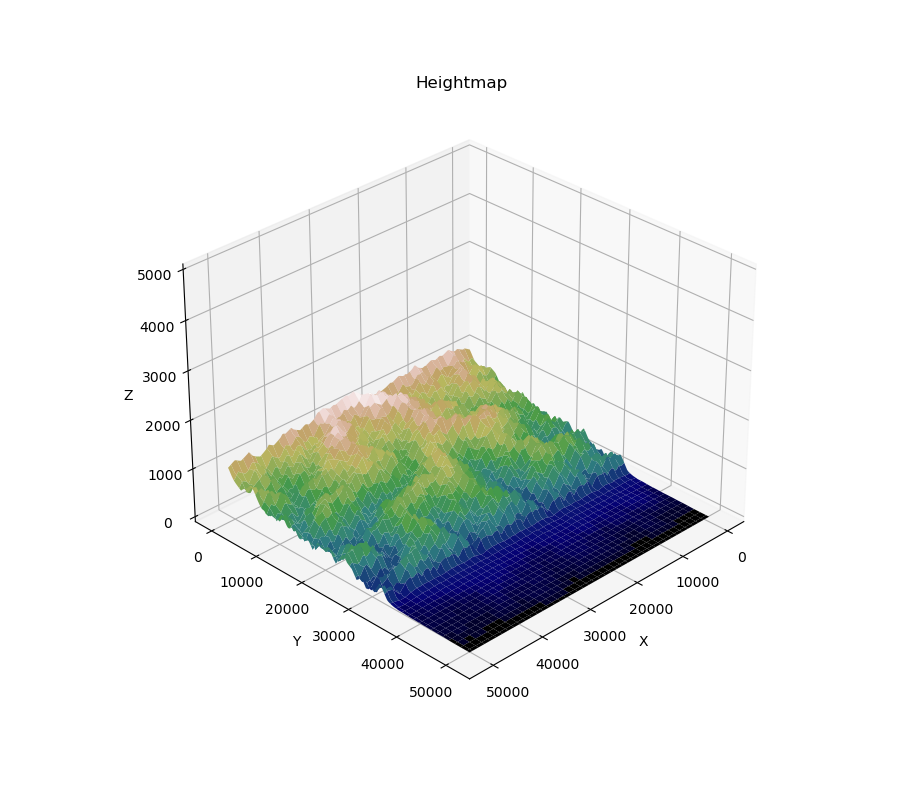

In [99]:

heightmap = ts.get_topo().reshape(ny,nx)

# Create a grid for the x and y coordinates
factor = 200
x, y = np.meshgrid(np.arange(heightmap.shape[1]) * factor, np.arange(heightmap.shape[0]) * factor)

# Plot the heightmap as a 3D surface
fig = plt.figure(figsize = (9,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 750, azim = 45, ro)

ax.plot_surface(x, y, heightmap, cmap = "gist_earth")

ax.set_zlim(0,5000)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Heightmap')
